In [1]:
# suppress warning
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline  

# define location for the input file
loc = 'http://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv'

# H2O Auto ML

Here is the link for [H2o AutoML document](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html)

In [2]:
import h2o
from h2o.automl import H2OAutoML

# Start an H2O virtual cluster that uses 6 gigs of RAM and 6 cores
# shut down the cluster use h2o.cluster().shutdown()
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.241-b07, mixed mode)
  Starting server from C:\Users\Gavin\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Gavin\AppData\Local\Temp\tmp33a9n3r9
  JVM stdout: C:\Users\Gavin\AppData\Local\Temp\tmp33a9n3r9\h2o_Gavin_started_from_python.out
  JVM stderr: C:\Users\Gavin\AppData\Local\Temp\tmp33a9n3r9\h2o_Gavin_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,4 months and 10 days !!!
H2O cluster name:,H2O_from_python_Gavin_sdmjyr
H2O cluster total nodes:,1
H2O cluster free memory:,3.495 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [3]:
h2o_df = h2o.import_file(loc)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [4]:
h2o_df.head()

Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,3,Mr. Owen Harris Braund,male,22,1,0,7.25
1,1,Mrs. John Bradley (Florence Briggs Thayer) Cumings,female,38,1,0,71.2833
1,3,Miss. Laina Heikkinen,female,26,0,0,7.925
1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35,1,0,53.1
0,3,Mr. William Henry Allen,male,35,0,0,8.05
0,3,Mr. James Moran,male,27,0,0,8.4583
0,1,Mr. Timothy J McCarthy,male,54,0,0,51.8625
0,3,Master. Gosta Leonard Palsson,male,2,3,1,21.075
1,3,Mrs. Oscar W (Elisabeth Vilhelmina Berg) Johnson,female,27,0,2,11.1333
1,2,Mrs. Nicholas (Adele Achem) Nasser,female,14,1,0,30.0708


In [5]:
# define predictors and target feature
X = h2o_df.drop(['Survived', 'Name'], axis = 1).columns
y = 'Survived'

In [6]:
# specify features as an enum type
for i in ['Survived', 'Sex']:
    h2o_df[i] = h2o_df[i].asfactor()

In [7]:
# split data into train and test
frs = h2o_df.split_frame([0.66], seed=12345)

htrain = frs[0]
htrain.frame_id = "Train"
htest= frs[1]
htest.frame_id = "Test"

In [8]:
# Starting h2o autoML model
aml = H2OAutoML(max_models = 30,  
                max_runtime_secs = 1800, 
                stopping_metric = 'AUC',
                nfolds = 5,
                stopping_tolerance = 0.001,
                stopping_rounds = 3,
                exclude_algos = ["GLM", "DeepLearning"], seed = 100)

In [9]:
aml.train(x=X, y =y, training_frame=htrain)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [10]:
# show model performance based on cross validation
aml.leaderboard

model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_grid_1_AutoML_20200318_104111_model_9,0.872112,0.414944,0.186382,0.356846,0.127339
StackedEnsemble_BestOfFamily_AutoML_20200318_104111,0.870762,0.41219,0.184982,0.357637,0.127904
GBM_grid_1_AutoML_20200318_104111_model_3,0.87061,0.420861,0.184766,0.356608,0.12717
GBM_grid_1_AutoML_20200318_104111_model_6,0.870033,0.424431,0.186598,0.360396,0.129886
GBM_3_AutoML_20200318_104111,0.867783,0.419992,0.171192,0.358285,0.128368
StackedEnsemble_AllModels_AutoML_20200318_104111,0.867733,0.411796,0.185413,0.356345,0.126982
GBM_2_AutoML_20200318_104111,0.862992,0.425653,0.184766,0.358252,0.128344
GBM_4_AutoML_20200318_104111,0.861249,0.42855,0.186059,0.362149,0.131152
XRT_1_AutoML_20200318_104111,0.859589,0.683446,0.191554,0.371395,0.137934
GBM_1_AutoML_20200318_104111,0.858043,0.444881,0.18746,0.367704,0.135206


In [11]:
# leader model is stored here
aml_model =aml.leader

In [12]:
# model performance on test data set
aml_perf = aml_model.model_performance(test_data=htest)
aml_perf.auc()

0.8681642342183928

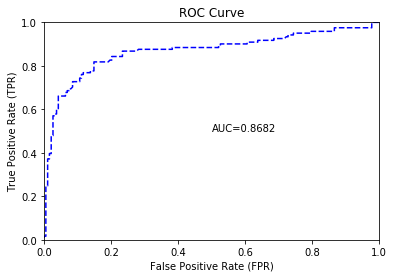

In [13]:
aml_perf.plot()

In [14]:
# prediction on test data set
aml_model.predict(htest)

gbm prediction progress: |████████████████████████████████████████████████| 100%


predict,p0,p1
1,0.0135063,0.986494
0,0.697023,0.302977
1,0.0969491,0.903051
1,0.169135,0.830865
1,0.0628877,0.937112
1,0.200884,0.799116
0,0.833525,0.166475
1,0.20578,0.79422
0,0.94476,0.05524
0,0.965521,0.0344785


# TPOT AutoML

Here is the link for [tpot document](https://epistasislab.github.io/tpot/)

In [15]:
import pandas as pd
import tpot
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split

In [16]:
# loc = r'C:\Users\Gavin\Documents\projects\playground\Data-Science-using-Python\titanic.csv'
input_df = pd.read_csv(loc)
input_df.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


tpot requires to take care of the feature encoding before feed into its AutoML process

In [17]:
titanic_df = input_df.select_dtypes(exclude=['object'])

# define predictors and target feature
X = titanic_df.drop(['Survived'], axis=1)
y = titanic_df['Survived']

In [18]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

In [19]:
# scale up: Increase the TPOT parameters like population_size, generations
# if regression problem, then use TPOTRegressor
tp = TPOTClassifier(
    generations=2, # number of iterations
    population_size=10, # number of individuals to retain in the genetic programming population every generation
    scoring= 'roc_auc',
    cv=2,
    n_jobs=-1,
    random_state=0,
    verbosity=0,
    config_dict= tpot.config.classifier_config_dict_light, # or use 'TPOT light'
    early_stop=5 # number of generations to check whether there is no improvement in optimization process
)

tp.fit(X_train, y_train)

TPOTClassifier(config_dict={'sklearn.cluster.FeatureAgglomeration': {'affinity': ['euclidean',
                                                                                  'l1',
                                                                                  'l2',
                                                                                  'manhattan',
                                                                                  'cosine'],
                                                                     'linkage': ['ward',
                                                                                 'complete',
                                                                                 'average']},
                            'sklearn.decomposition.PCA': {'iterated_power': range(1, 11),
                                                          'svd_solver': ['randomized']},
                            'sklearn.feature_selection.SelectFwe': {'alpha': array([0.

In [20]:
# model performance on test data set
tp.score(X_test, y_test)

0.730544937763403

In [21]:
# prediction on test data set
tp.predict_proba(X_test)[:10]

array([[0.96551724, 0.03448276],
       [0.96551724, 0.03448276],
       [0.82089552, 0.17910448],
       [0.96551724, 0.03448276],
       [0.5375    , 0.4625    ],
       [0.15      , 0.85      ],
       [0.7254902 , 0.2745098 ],
       [0.7254902 , 0.2745098 ],
       [0.7254902 , 0.2745098 ],
       [0.41666667, 0.58333333]])

# Other AutoML Packages

there are many packages that can run AutoML: <br>
https://github.com/AxeldeRomblay/MLBox <br> 
https://github.com/EpistasisLab/tpot <br>
https://github.com/automl/auto-sklearn <br>
https://github.com/flennerhag/mlens <br>
https://github.com/rasbt/mlxtend <br>
https://github.com/ClimbsRocks/auto_ml